# Image classification with TensorFlow 

Based on an original notebook by the TensorFlow authors, licensed under Apache 2.0.

**Note: You need to sign in to Google to run this notebook.**

Use **Shift + Enter** to run the cells. When prompted, click **Run anyway** then **Yes**. Try it on this cell...

In [2]:
print("It worked!")

It worked!


## Overview

In this notebook, we're going to classify some images of fossils.

A 'notebook' is an interactive coding and note-taking environment. We're going to be using some cutting edge technology, right in your browser. We will see:

- A deep neural network in action.
- Google's TensorFlow deep learning library.
- Google's 'tensor processing unit' (TPU) deep learning hardware acceleration.
- All of this is running on Google's infrastructure, for free.

There are fewer than 100 lines of code altogether.

## Prepare the data

We'll begin by downloading the dataset. Run this cell:

In [3]:
import requests
import numpy as np
from io import BytesIO

X_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/image_X.npy")
y_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/integer_y.npy")

X = np.load(BytesIO(X_.content))
y = np.load(BytesIO(y_.content))

print("Data loaded!")

Data loaded!


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

y_val

array([1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2,
       0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1, 0, 2, 2, 0, 2, 2, 1,
       0, 0, 2, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 0, 0, 1,
       0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2, 0, 2, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 2, 0, 1, 1, 0, 2, 2, 0, 2, 1, 1, 2, 1, 2, 0, 2,
       2, 2, 1, 0, 0, 1, 1, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0])

## Define the model

The following example uses a standard conv-net that has 3 layers with drop-out and batch normalization between each layer.

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)    

## Train on the TPU

To begin training, construct the model on the TPU and then compile it.

The following code demonstrates the use of a generator function and `fit_generator` to train the model.  Alternately, you can pass in `x_train` and `y_train` to `tpu_model.fit()`.

In [6]:
import os

try:
    tpu_model = tf.contrib.tpu.keras_to_tpu_model(
        model,
        strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
        )
    )
except KeyError:  # os.environ fails if no TPU
    tpu_model = model

tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

def train_gen():
    """Training, no batches.
    """
    while True:
        yield X_train, y_train
    

tpu_model.fit_generator(
    train_gen(),
    epochs=1,
    steps_per_epoch=1000,
    validation_data=(X_val, y_val),
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.10.217.58:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 258071649689126193)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10282156229969413922)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17994883662757149183)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

## Check the results (inference)

Now that you are done training, see how well the model can predict fossil types.

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(2, 32, 32, 1), dtype=tf.float32, name='batch_normalization_v1_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for batch_normalization_v1_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.7976281642913818 secs


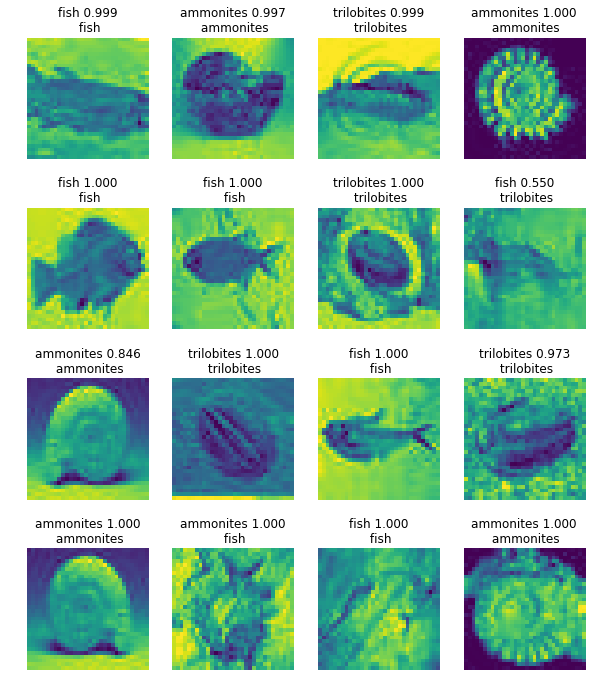

In [7]:
LABEL_NAMES = ['ammonites', 'fish', 'trilobites']

try:
    cpu_model = tpu_model.sync_to_cpu()
except AttributeError:
    cpu_model = tpu_model  # We were never on TPUs

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, actuals):
    n = images.shape[0]
    nc = int(np.ceil(n / 4))
    f, axes = pyplot.subplots(nc, 4)
    for i in range(nc * 4):
        y = i // 4
        x = i % 4
        axes[x, y].axis('off')

        pred = LABEL_NAMES[np.argmax(predictions[i])]
        actual = LABEL_NAMES[actuals[i]]
        conf = np.max(predictions[i])
        if i > n:
            continue
        axes[x, y].imshow(images[i])
        axes[x, y].set_title("{} {:.3f}\n {}".format(pred, conf, actual))

    pyplot.gcf().set_size_inches(10, 12)  

plot_predictions(np.squeeze(X_val[:16]), 
                 tpu_model.predict(X_val[:16]),
                 np.squeeze(y_val[:16])
                )